In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function,division
from Pic.maxent_font import tick_font
from Utils.gridCV import gridCV

In [2]:
image_path = "/Users/chaoxu/code/local-spark/Data/image_qiancheng"
ratio = 0.05
model = 'tree'
version = '6v0.09'

In [3]:
df = pd.read_csv("/Users/chaoxu/code/local-spark/Data/qiancheng_data/qiancheng_sample_new_merge_{0}/data.csv".format(ratio))

In [4]:
def merge_ua_proxy(row):
    if row['uaMismatch.value'] >= 1 or row['proxyIP.value'] >=1:
        return 1
    else:
        return 0
df['proxy_ua'] = df.apply(merge_ua_proxy,axis=1)


In [5]:
def resample(data, positiveRatio=0.04):
    positive = data[data["label"] == 1]
    negative = data[data["label"] == 0]
    n = int((1 - positiveRatio) / positiveRatio) * positive.shape[0]
    print(n)
    _negative = negative.sample(n=n)
    df = pd.concat([positive, _negative])
    return df

In [6]:
df[['label']]=df[['label']].fillna(0)

In [7]:
df.loc[(df.label == 1) & (df.os == 'ios')]['maxent_id'].drop_duplicates().count()

159

In [8]:
df.loc[(df.label == 1) & (df.os == 'android')]['maxent_id'].drop_duplicates().count()

303

In [9]:
from datetime import datetime, timedelta
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]) + timedelta(hours=8)
df = df.sort_values(by="timestamp")
# df_maxent_id = df['maxent_id'].reset_index(drop=True)
# df_ios_maxent_id = df.loc[df.os == 'ios']['maxent_id'].reset_index(drop=True)
# df_android_maxent_id = df.loc[df.os == 'android']['maxent_id'].reset_index(drop=True)
# df = df.drop(['idcIP.anomaly', 'cracked.anomaly', 'uaMismatch.anomaly','uaMismatch.value','proxyIP.value','proxyIP.anomaly',"timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df = df.drop(["timestamp","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)

df[['label']]=df[['label']].fillna(0)
df[['label']] = df[['label']].astype(int)
df = df.loc[df['event_type'] =='ACT']
df = df.drop(['event_type'],axis=1)

In [10]:
import re
anormaly = re.compile('.*anomaly$')
anormaly_match = np.vectorize(lambda x:bool(anormaly.match(x)))
anormaly_cols = df.columns.values[anormaly_match(df.columns.values)]

value = re.compile('.*value$')
value_match = np.vectorize(lambda x:bool(value.match(x)))
value_cols = df.columns.values[value_match(df.columns.values)]

count = re.compile('.*counts$')
count_match = np.vectorize(lambda x:bool(count.match(x)))
count_cols = df.columns.values[count_match(df.columns.values)]

loan = re.compile('.*loan$')
loan_match = np.vectorize(lambda x:bool(loan.match(x)))
loan_cols = df.columns.values[loan_match(df.columns.values)]

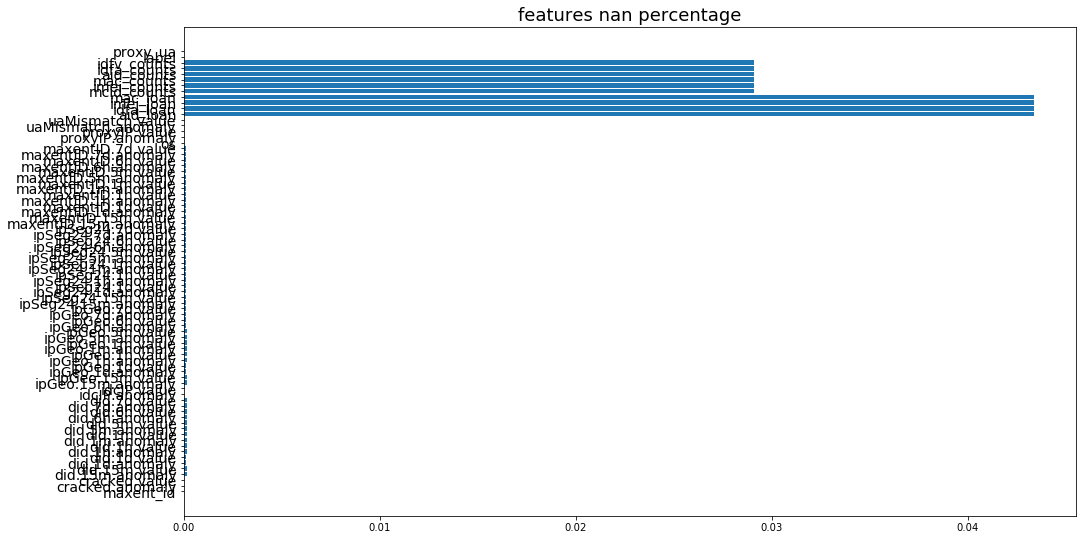

In [11]:
cols = df.columns
fig, ax = plt.subplots(figsize=(16,9))
ax.barh(range(len(cols)),df[cols].isnull().sum()/df.shape[0])
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols, size=14)
ax.set_title('features nan percentage',size= 18)
plt.show()

In [12]:
df[loan_cols]=df[loan_cols].fillna(0)

In [13]:
df[anormaly_cols] = df[anormaly_cols].fillna(1)
df[value_cols] = df[value_cols].fillna(1)

In [14]:
obj_df = df.select_dtypes(include=['object'])
obj_df.columns

Index([u'maxent_id', u'os'], dtype='object')

In [15]:
bool_df = df.select_dtypes(include=['bool'])
bool_df.columns

Index([u'cracked.value', u'idcIP.value', u'proxyIP.value',
       u'uaMismatch.value'],
      dtype='object')

In [16]:
df[count_cols]=df[count_cols].fillna(0)

In [17]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df[show_missing()].isnull().sum()

Series([], dtype: float64)

整体的label平衡性

In [18]:
df.label.value_counts(normalize=True)

0    0.915517
1    0.084483
Name: label, dtype: float64

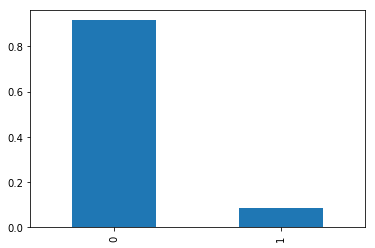

In [19]:
df.label.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [20]:
df_ios = df.loc[df.os == 'ios']

In [21]:
obj_cols = obj_df.columns.values.tolist()
print(obj_cols)
bool_cols = bool_df.columns.values.tolist()
print(bool_cols)
encoder_cols = obj_cols + bool_cols
print(encoder_cols)

['maxent_id', 'os']
['cracked.value', 'idcIP.value', 'proxyIP.value', 'uaMismatch.value']
['maxent_id', 'os', 'cracked.value', 'idcIP.value', 'proxyIP.value', 'uaMismatch.value']


In [22]:
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [23]:
df_ios = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_ios)

In [24]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df_ios[show_missing()].isnull().sum()

Series([], dtype: float64)

In [25]:
ios_drop = ['os','aid_loan','imei_loan','mac_loan','imei_counts','mac_counts','aid_counts']
df_ios=df_ios.drop(ios_drop,axis=1)

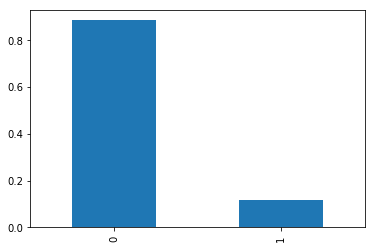

In [26]:
df_ios.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/ios_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [27]:
from sklearn.cross_validation import train_test_split
def splitData(df, ratio):
    """
    """
    positiveData = df[df["label"] == 1].copy(deep=True)
    _positiveTrain, _positiveTest = train_test_split(positiveData, train_size=ratio)
    negativeData = df[df["label"] == 0].copy(deep=True)
    _negativeTrain, _negativeTest = train_test_split(negativeData, train_size=ratio)
    train_set = pd.concat([_positiveTrain, _negativeTrain])
    test_set = pd.concat([_positiveTest, _negativeTest])
    return train_set, test_set

df_ios_train, df_ios_test = splitData(df_ios,0.3)
df_ios_maxent_id = df_ios_test['maxent_id'].reset_index(drop=True)
X_ios_train = df_ios_train.ix[:, df_ios_train.columns != 'label'].drop(['maxent_id'],axis=1)
X_ios_test  = df_ios_test.ix[:, df_ios_test.columns != 'label'].drop(['maxent_id'],axis=1)
y_ios_train = df_ios_train.ix[:, df_ios_train.columns == 'label']
y_ios_test  = df_ios_test.ix[:, df_ios_test.columns == 'label']
print("Number transactions ios train dataset: ", X_ios_train.shape[0])
print("Number transactions ios train dataset: ", y_ios_train.shape[0])
print("Number transactions ios test dataset: ", X_ios_test.shape[0])
print("Total number of ios transactions: ", X_ios_train.size)

Number transactions ios train dataset:  5401
Number transactions ios train dataset:  5401
Number transactions ios test dataset:  12604
Total number of ios transactions:  372669


/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
from __future__ import print_function,division
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('label 1')
    plt.xlabel('label 0')

In [29]:
def get_ios_group_label(row):
#     print(row['y_ios_test'].values)
#     if row['y_ios_test'].values[0] == 1:
    return row['y_ios_pred'].max()
#     else:
#         return row['y_ios_pred'].min()

In [30]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,precision_score,classification_report
# from sklearn.ensemble import RandomForestClassifier
# params = {'max_features':'auto', 'max_depth': 3, 'min_samples_split': 5, \
#             'class_weight':'balanced','oob_score':True}
# params['n_estimators'] = 2
# params['n_jobs'] = 50
# forest = RandomForestClassifier(**params)
# clf_a = forest.fit(X_ios_train,y_ios_train.values.ravel())
# y_ios_pred = clf_a.predict(X_ios_test)

# df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
# df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
# df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
# df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

In [31]:
from sklearn import tree
from IPython.display import Image
import pydotplus
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [32]:
tree_base_params = {
    'criterion' : 'gini',
    'random_state' : 27,
    'class_weight':"balanced"
}

In [33]:
params_ios = {}
params_ios.update(tree_base_params)
params_ios

{'class_weight': 'balanced', 'criterion': 'gini', 'random_state': 27}

In [34]:
# from collections import OrderedDict
# all_test_params = OrderedDict()
cv_params = {
    'pre_dispatch': '2*n_jobs', 
    'refit':True,
    'scoring':'roc_auc',
#     'scoring':'f1_macro',
#     'scoring':'f1_weighted',
#     'scoring':'average_precision',
#     'scoring':'accuracy',
#     'scoring':'recall',
    'cv':5,
    'verbose':0
}
all_test_params = {
    'max_depth':range(4,20,2),    
    'max_leaf_nodes':range(2,20,2),
    'min_samples_leaf':range(30,100,10),
    'min_samples_split':range(30,100,10),
    'min_impurity_decrease':[i/100.0 for i in range(0,5)]
}
# all_test_params = {
# #     'max_depth':range(1,5,1),
#     'max_depth':range(4,20,2), 
#     'min_samples_leaf':range(80,160,10),
#     'min_samples_split':range(10,110,10),
#     'max_leaf_nodes':range(10,100,10),
#     'max_features':['sqrt','log2',None],
#     'min_impurity_decrease':[i/100.0 for i in range(0,5)]
# }

find best params of {'min_samples_split': [30, 40, 50, 60, 70, 80, 90]}
find best params of {'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_impurity_decrease': [0.0, 0.01, 0.02, 0.03, 0.04]}
find best params of {'max_depth': [4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90]}


/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


get grid score is [mean: 0.81043, std: 0.01582, params: {'min_samples_leaf': 30}, mean: 0.81066, std: 0.01567, params: {'min_samples_leaf': 40}, mean: 0.81063, std: 0.01585, params: {'min_samples_leaf': 50}, mean: 0.81214, std: 0.01469, params: {'min_samples_leaf': 60}, mean: 0.81403, std: 0.01330, params: {'min_samples_leaf': 70}, mean: 0.80848, std: 0.01508, params: {'min_samples_leaf': 80}, mean: 0.79009, std: 0.01432, params: {'min_samples_leaf': 90}]
get best parameters is {'random_state': 27, 'criterion': 'gini', 'min_samples_split': 30, 'max_leaf_nodes': 18, 'min_samples_leaf': 70, 'max_depth': 8, 'min_impurity_decrease': 0.0, 'class_weight': 'balanced'}
get best score is 0.814033928332


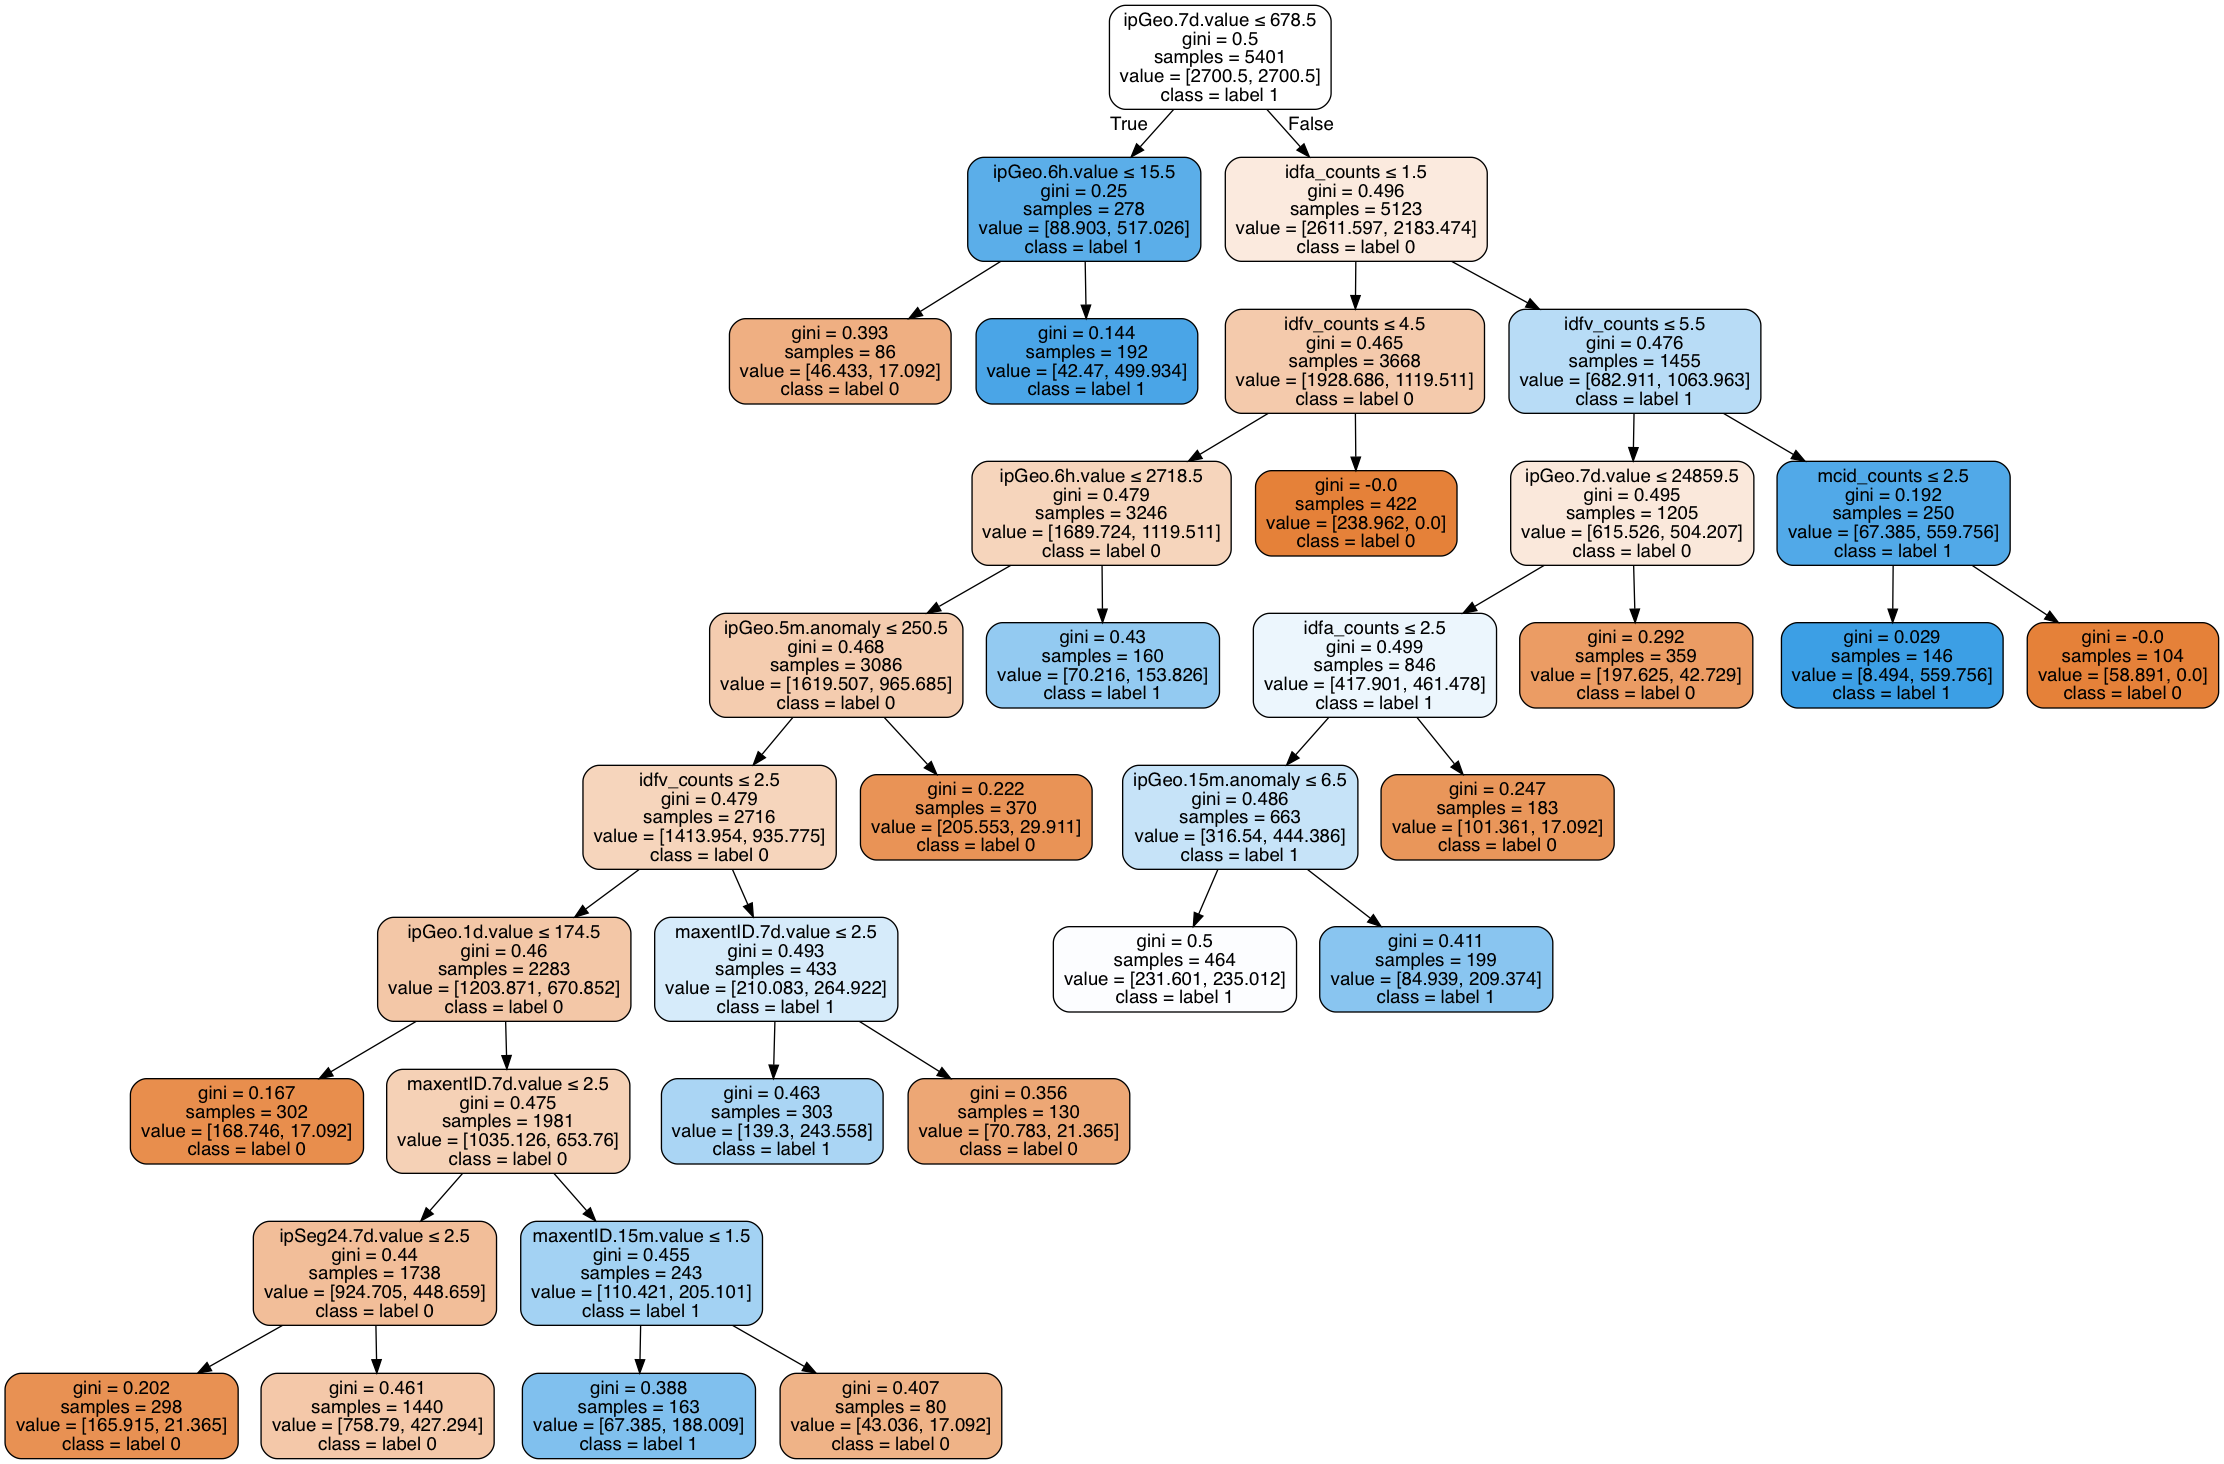

In [35]:
from sklearn import tree
from IPython.display import Image
import pydotplus
# X_ios_cols = X_ios_train.columns
X_ios_train_cv = X_ios_train
y_ios_train_cv = y_ios_train['label']
ios_params,_clf = gridCV(clf=tree.DecisionTreeClassifier,X=X_ios_train_cv,y=y_ios_train_cv,
                         base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_ios = tree.DecisionTreeClassifier(**ios_params)
clf_0 = clf_ios.fit(X_ios_train, y_ios_train)
ios_dot_data = tree.export_graphviz(clf_0, out_file=None, feature_names=X_ios_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(ios_dot_data)
Image(graph.create_png())

In [36]:
save_path = image_path + "/ios_tree-{0}-{1}-{2}.png".format(version,ratio,model)
graph.write_png(save_path)

True

In [37]:
X_ios_train.shape

(5401, 69)

869676
2647
Recall metric in the testing dataset:  0.453333333333
Precision metric in the testting dataset: 0.120353982301
f2 metric in the testting dataset: 3.42647058824
             precision    recall  f1-score   support

          0       0.96      0.80      0.87      2497
          1       0.12      0.45      0.19       150

avg / total       0.91      0.78      0.83      2647



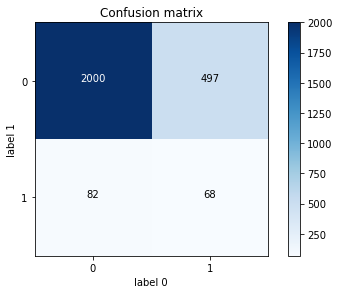

In [38]:
y_ios_pred = clf_0.predict(X_ios_test)

df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

df_pred_g_apply=df_pred_g.apply(lambda x:get_ios_group_label(x)).reset_index(name='y_ios_pred_max')

y_ios_test_m = df_pred_g_apply['y_ios_test']
y_ios_pred_m = df_pred_g_apply['y_ios_pred_max']

print(X_ios_test.size)
print(y_ios_test_m.size)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_ios_test_m,y_ios_pred_m)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_ios_test_m, y_ios_pred_m, target_names=['0','1']))
save_path = image_path + "/tree_ios_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

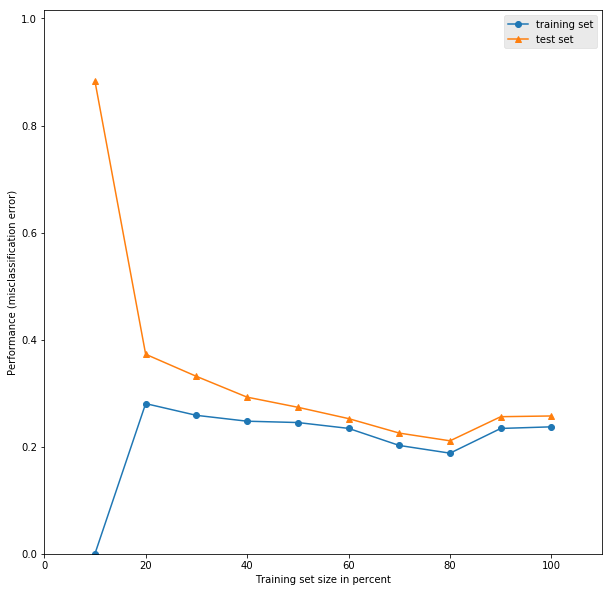

In [39]:
from mlxtend.plotting import plot_learning_curves
y_ios_train_f = y_ios_train.label.astype(float)
y_ios_test_f = y_ios_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_ios_train, y_ios_train_f, X_ios_test, y_ios_test_f, clf_0, print_model=False,style='ggplot')

save_path = image_path + "/ios_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


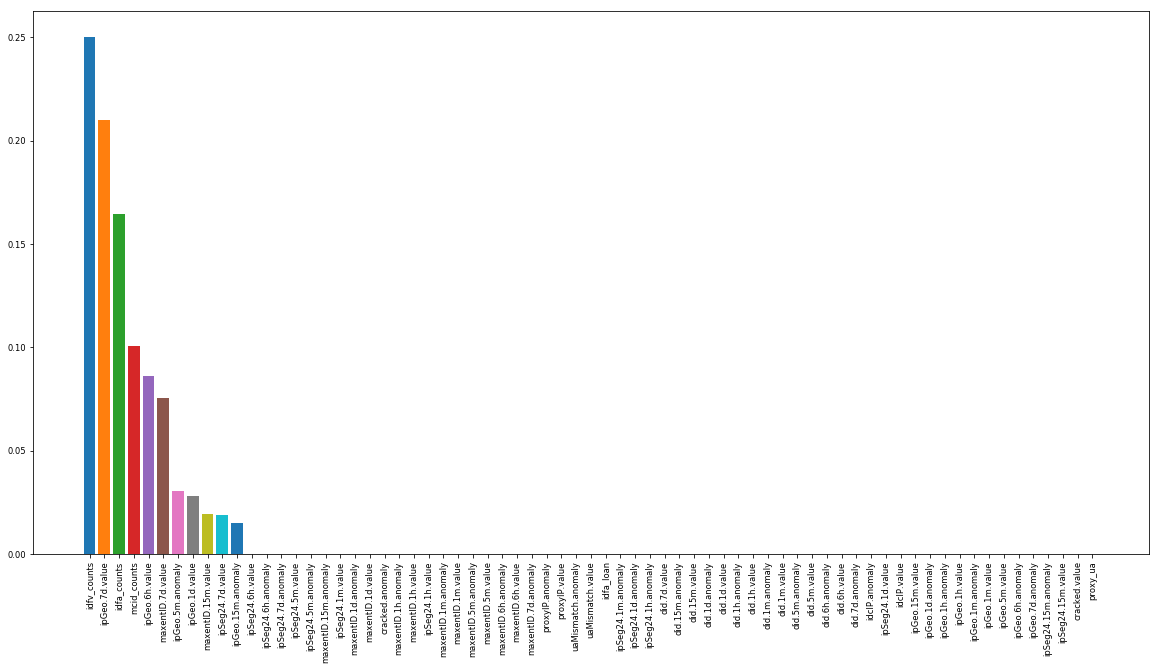

In [40]:
df_feature_ios = pd.DataFrame(X_ios_train.columns.values,columns=['column'])
df_importance = pd.DataFrame(clf_0.feature_importances_,columns=['feature importances'])
df_ios_fim = pd.concat([df_feature_ios,df_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_ios_fim=df_ios_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_ios_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_ios_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/ios_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [41]:
df_android = df.loc[df.os == 'android']
df_android = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_android)

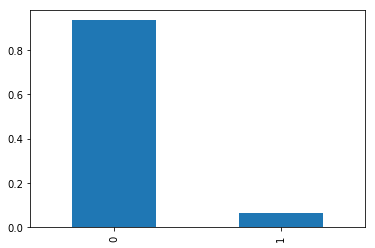

In [42]:
df_android.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/android_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [43]:
df_android[show_missing()].isnull().sum()

Series([], dtype: float64)

In [44]:
android_drop = ['os','idfa_loan','idfa_counts', u'idfv_counts','imei_loan']
df_android =df_android.drop(android_drop,axis=1)

In [45]:
df_android_train, df_android_test = splitData(df_android,0.3)
df_android_maxent_id = df_android_test['maxent_id'].reset_index(drop=True)
X_android_train = df_android_train.ix[:, df_android_train.columns != 'label'].drop(['maxent_id'],axis=1)
X_android_test  = df_android_test.ix[:, df_android_test.columns != 'label'].drop(['maxent_id'],axis=1)
y_android_train = df_android_train.ix[:, df_android_train.columns == 'label']
y_android_test  = df_android_test.ix[:, df_android_test.columns == 'label']
print("Number transactions android train dataset: ", X_android_train.shape[0])
print("Number transactions android train dataset: ", y_android_train.shape[0])
print("Number transactions android test dataset: ", X_android_test.shape[0])
print("Total number of android transactions: ", X_android_train.size)

Number transactions android train dataset:  9597
Number transactions android train dataset:  9597
Number transactions android test dataset:  22396
Total number of android transactions:  681387


In [46]:
params_android = {}
params_android.update(tree_base_params)
params_android

{'class_weight': 'balanced', 'criterion': 'gini', 'random_state': 27}

find best params of {'min_samples_split': [30, 40, 50, 60, 70, 80, 90]}
find best params of {'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_impurity_decrease': [0.0, 0.01, 0.02, 0.03, 0.04]}
find best params of {'max_depth': [4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90]}


/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


get grid score is [mean: 0.66246, std: 0.02072, params: {'min_samples_leaf': 30}, mean: 0.66328, std: 0.01823, params: {'min_samples_leaf': 40}, mean: 0.65933, std: 0.02031, params: {'min_samples_leaf': 50}, mean: 0.65933, std: 0.02031, params: {'min_samples_leaf': 60}, mean: 0.66019, std: 0.02294, params: {'min_samples_leaf': 70}, mean: 0.65793, std: 0.01911, params: {'min_samples_leaf': 80}, mean: 0.66171, std: 0.02017, params: {'min_samples_leaf': 90}]
get best parameters is {'random_state': 27, 'criterion': 'gini', 'min_samples_split': 30, 'max_leaf_nodes': 18, 'min_samples_leaf': 40, 'max_depth': 12, 'min_impurity_decrease': 0.0, 'class_weight': 'balanced'}
get best score is 0.663278004197


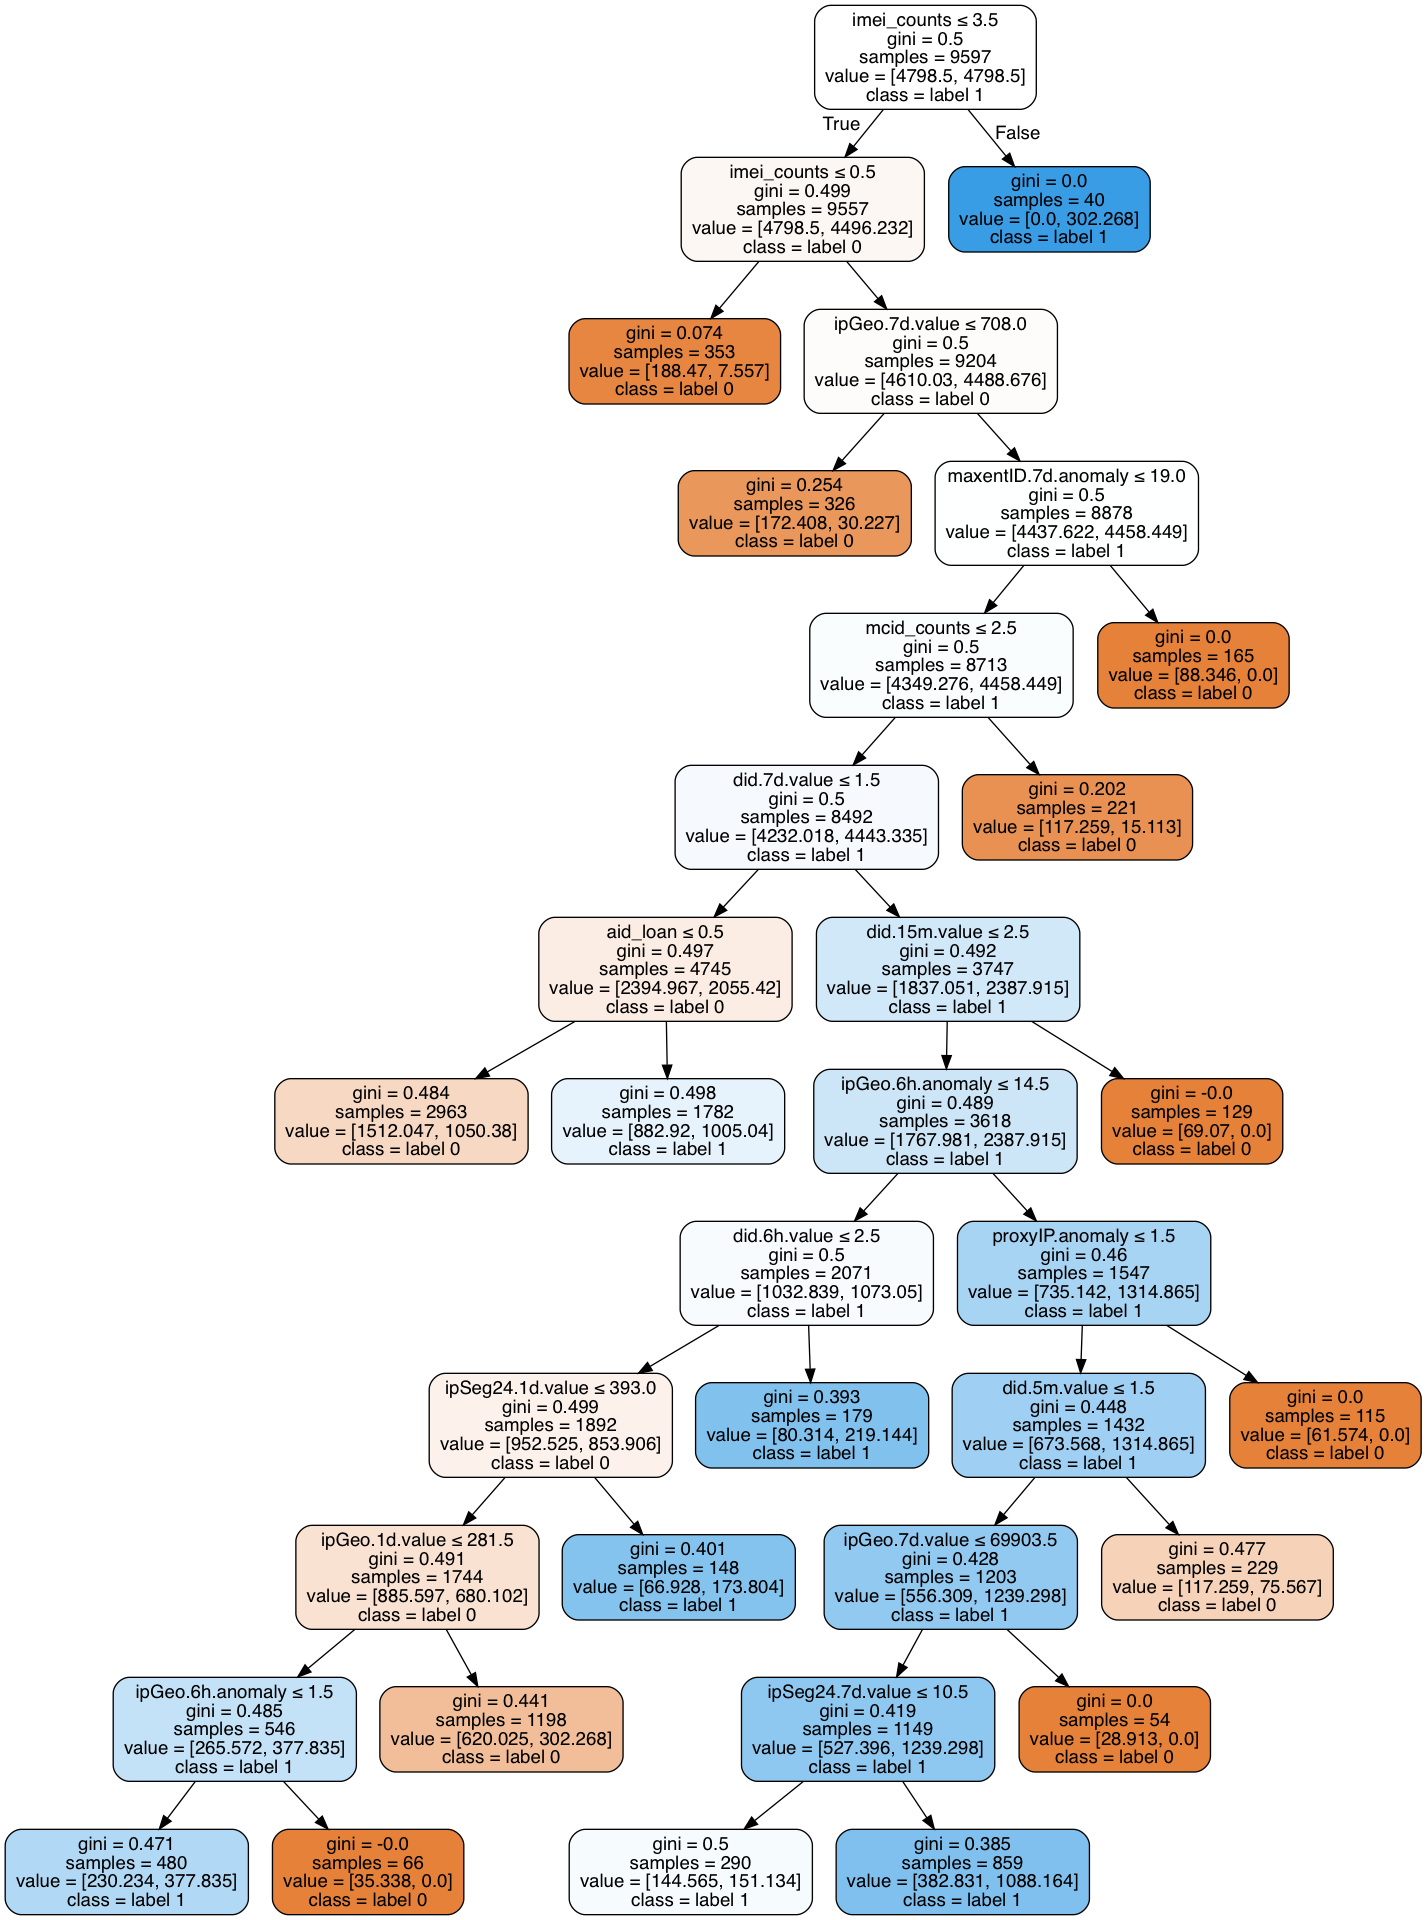

In [47]:
X_android_cols = X_android_train.columns
X_android_train_cv = X_android_train[X_android_cols]
y_android_train_cv = y_android_train['label']
android_params,_clf = gridCV(clf=tree.DecisionTreeClassifier,X=X_android_train_cv,y=y_android_train_cv,
                             base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_android = tree.DecisionTreeClassifier(**android_params)
clf_1 = clf_android.fit(X_android_train, y_android_train)

dot_data_android = tree.export_graphviz(clf_1, out_file=None, feature_names=X_android_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(dot_data_android)
# graph.write_pdf("Odec_tree.pdf")
Image(graph.create_png())

In [48]:
save_path = image_path + "/android_tree-{0}-{1}-{2}.png".format(version,ratio,model)
print(save_path)
graph.write_png(save_path)

/Users/chaoxu/code/local-spark/Data/image_qiancheng/android_tree-6v0.09-0.05-tree.png


True

In [49]:
def get_android_group_label(row):
#     if row['y_android_test'].values[0] == 1:
    return row['y_android_pred'].max()
#     else:
#         return row['y_android_pred'].min()


(22396, 71)
(5492,)
Recall metric in the testing dataset:  0.60071942446
Precision metric in the testting dataset: 0.0765352887259
f2 metric in the testting dataset: 3.94491017964
             precision    recall  f1-score   support

          0       0.97      0.61      0.75      5214
          1       0.08      0.60      0.14       278

avg / total       0.92      0.61      0.72      5492



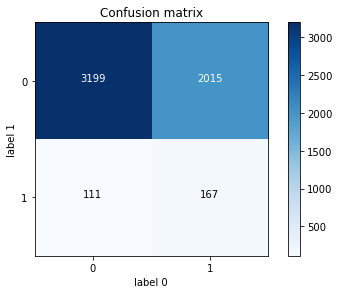

In [50]:
y_android_pred = clf_1.predict(X_android_test)

df_y_android_pred = pd.DataFrame(y_android_pred,columns=['y_android_pred'])
df_y_android_test = pd.DataFrame(y_android_test.values,columns=['y_android_test'])
df_android_pred = pd.concat([df_android_maxent_id,df_y_android_pred,df_y_android_test],axis=1)
df_android_pred_g = df_android_pred.groupby(['maxent_id','y_android_test'])
# df_android_pred_g['y_android_pred_max'] = df_android_pred_g.apply(lamda x:get_android_group_label(x))

df_android_pred_g_apply=df_android_pred_g.apply(lambda x:get_android_group_label(x)).reset_index(name='y_android_pred_max')

y_android_test_m = df_android_pred_g_apply['y_android_test']
y_android_pred_m = df_android_pred_g_apply['y_android_pred_max']
print(X_android_test.shape)
print(y_android_test_m.shape)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_android_test_m,y_android_pred_m)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_android_test_m, y_android_pred_m, target_names=['0','1']))
save_path = image_path + "/tree_android_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

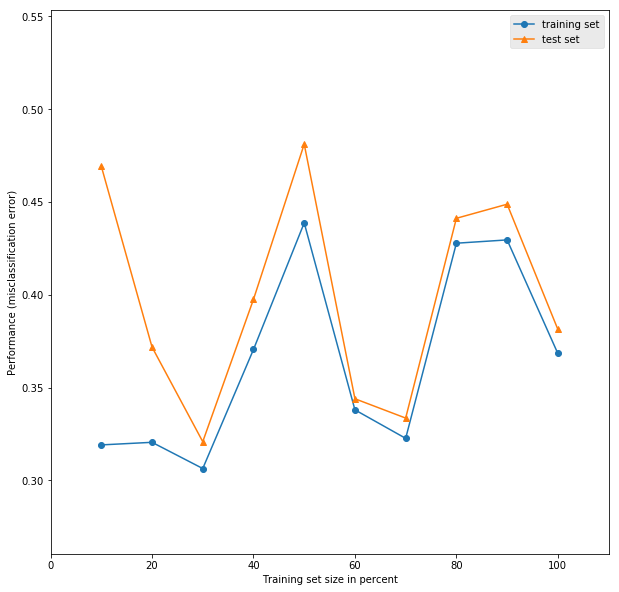

In [51]:
from mlxtend.plotting import plot_learning_curves
y_android_train_f = y_android_train.label.astype(float)
y_android_test_f = y_android_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_android_train, y_android_train_f, X_android_test, y_android_test_f, clf_1, print_model=False,style='ggplot')

save_path = image_path + "/android_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


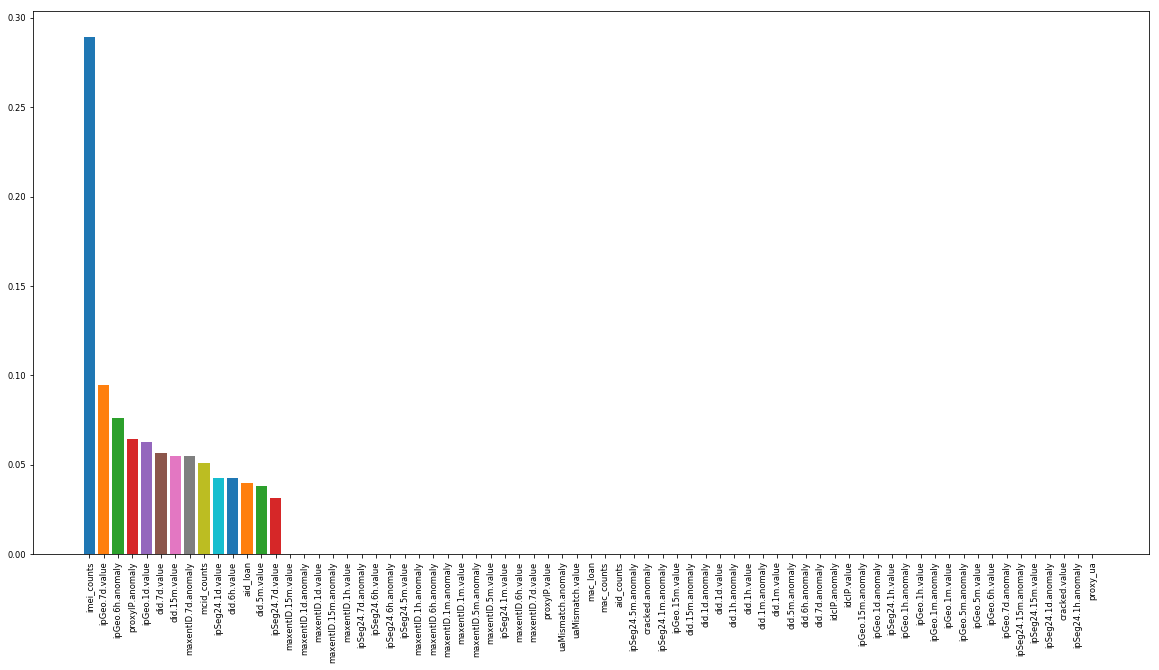

In [52]:
df_feature_android = pd.DataFrame(X_android_train.columns.values,columns=['column'])
df_android_importance = pd.DataFrame(clf_1.feature_importances_,columns=['feature importances'])
df_android_fim = pd.concat([df_feature_android,df_android_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_android_fim=df_android_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_android_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_android_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)
save_path = image_path + "/android_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()